In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utils.minmax_normalizer import MinMaxNormalization
import time

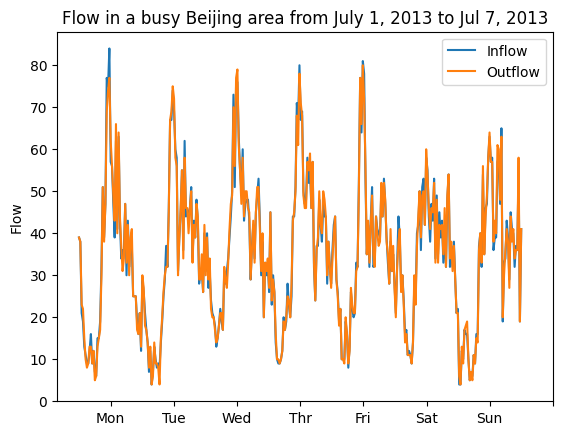

In [2]:
flow2013 = np.load('./Datasets/TaxiBJ/TaxiBJ2013.npy')
# flow2014 = np.load('./Datasets/TaxiBJ/TaxiBJ2014.npy')
# flow2015 = np.load('./Datasets/TaxiBJ/TaxiBJ2015.npy')
# flow2016_1 = np.load('./Datasets/TaxiBJ/TaxiBJ2016_1.npy')
# flow2016_2 = np.load('./Datasets/TaxiBJ/TaxiBJ2016_2.npy')
# flow2016 = np.vstack((flow2016_1, flow2016_2))
ext2013 = np.load('./Datasets/TaxiBJ/TaxiBJext2013.npy')
# ext2014 = np.load('./Datasets/TaxiBJ/TaxiBJext2014.npy')
# ext2015 = np.load('./Datasets/TaxiBJ/TaxiBJext2015.npy')
# ext2016 = np.load('./Datasets/TaxiBJ/TaxiBJext2016.npy')  
x, y = 10, 10
fig = plt.figure()
in_flow = flow2013[24*2*7*0:24*2*7*1,0,x,y]
out_flow = flow2013[24*2*7*0:24*2*7*1,1,x,y]
t = np.linspace(1, 168*2, num=168*2)
plt.plot(t,in_flow,label='Inflow')
plt.plot(t,out_flow,label='Outflow')
plt.xticks(np.linspace(1+12*2, (168+12)*2, num=8),['Mon','Tue','Wed','Thr','Fri','Sat','Sun',''])
plt.title('Flow in a busy Beijing area from July 1, 2013 to Jul 7, 2013')
plt.ylabel('Flow')
plt.legend(loc='upper right')
plt.show()

In [3]:
def get_taxibj_data(flow_data,ext_data,n_closeness,n_period,n_trend,tt_split,g_closeness=1,g_period=24*2,g_trend=24*2*7, mmn=None):
    data_len, feature, map_height, map_width = flow_data.shape
    _, ext_dim = ext_data.shape
    assert ((n_closeness,n_period,n_trend) < (7,4,3))
    start_idx = g_trend*n_trend
    total_samples = data_len-start_idx
    n_train = int(total_samples*tt_split)
    n_test = total_samples-n_train
    if mmn == None:
        mmn = MinMaxNormalization()
        mmn.fit(flow_data)
    flow_data = mmn.transform(flow_data)
    
    tstamp_train = np.zeros(n_train)
    y_train = np.zeros((n_train,2,map_height,map_width))
    x_closeness_train = np.zeros((n_train,n_closeness,2,map_height,map_width))    
    x_period_train = np.zeros((n_train,n_period,2,map_height,map_width))
    x_trend_train = np.zeros((n_train,n_trend,2,map_height,map_width))
    x_ext_train = np.zeros((n_train,ext_dim))
    k = 0
    for i in range(start_idx,start_idx+n_train):    
        tstamp_train[k] = i
        y_train[k,:,:,:] = flow_data[i,:,:,:]
        x_ext_train[k,:] = ext_data[i,:]
        l = 0
        for j in range(i-g_trend, i-g_trend*(n_trend+1), -g_trend):
            x_trend_train[k,l,:,:,:] = flow_data[j,:,:,:]
            l += 1        
        l = 0
        for j in range(i-g_period, i-g_period*(n_period+1), -g_period):            
            x_period_train[k,l,:,:,:] = flow_data[j,:,:,:]
            l += 1
        l = 0
        for j in range(i-g_closeness, i-g_closeness*(n_closeness+1), -g_closeness):            
            x_closeness_train[k,l,:,:,:] = flow_data[j,:,:,:]
            l += 1
        k += 1    
    x_closeness_train = x_closeness_train.reshape(n_train,-1,map_height,map_width)
    x_period_train = x_period_train.reshape(n_train,-1,map_height,map_width)
    x_trend_train = x_trend_train.reshape(n_train,-1,map_height,map_width)
    
    start_idx += n_train
    tstamp_test = np.zeros(n_test)
    y_test = np.zeros((n_test,2,map_height,map_width))
    x_closeness_test = np.zeros((n_test,n_closeness,2,map_height,map_width))    
    x_period_test = np.zeros((n_test,n_period,2,map_height,map_width))
    x_trend_test = np.zeros((n_test,n_trend,2,map_height,map_width))
    x_ext_test = np.zeros((n_test,ext_dim))
    k = 0
    for i in range(start_idx,start_idx+n_test):
        tstamp_test[k] = i
        y_test[k,:,:,:] = flow_data[i,:,:,:]
        x_ext_test[k,:] = ext_data[i,:]
        l = 0
        for j in range(i-g_trend, i-g_trend*(n_trend+1), -g_trend):
            x_trend_test[k,l,:,:,:] = flow_data[j,:,:,:]
            l += 1        
        l = 0
        for j in range(i-g_period, i-g_period*(n_period+1), -g_period):            
            x_period_test[k,l,:,:,:] = flow_data[j,:,:,:]
            l += 1
        l = 0
        for j in range(i-g_closeness, i-g_closeness*(n_closeness+1), -g_closeness):            
            x_closeness_test[k,l,:,:,:] = flow_data[j,:,:,:]
            l += 1
        k += 1
    x_closeness_test = x_closeness_test.reshape(n_test,-1,map_height,map_width)
    x_period_test = x_period_test.reshape(n_test,-1,map_height,map_width)
    x_trend_test = x_trend_test.reshape(n_test,-1,map_height,map_width)
    
    return tstamp_train, x_closeness_train, x_period_train, x_trend_train, x_ext_train, y_train, \
           x_closeness_test, x_period_test, x_trend_test, x_ext_test, y_test

# d = get_taxibj_data(flow2013,ext2013,4,1,1,0.8)

In [4]:
import torch
from torch.utils.data import Dataset
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class TaxiBJDataset(Dataset):
    def __init__(self,path,n_closeness,n_period,n_trend,tt_split,train=True):
        flow2013 = np.load(path+'TaxiBJ2013.npy')
        flow2014 = np.load(path+'TaxiBJ2014.npy')
        flow2015 = np.load(path+'TaxiBJ2015.npy')
        flow2016_1 = np.load(path+'TaxiBJ2016_1.npy')
        flow2016_2 = np.load(path+'TaxiBJ2016_2.npy')
        flow2016 = np.vstack((flow2016_1, flow2016_2))
        ext2013 = np.load(path+'TaxiBJext2013.npy')
        ext2014 = np.load(path+'TaxiBJext2014.npy')
        ext2015 = np.load(path+'TaxiBJext2015.npy')
        ext2016 = np.load(path+'TaxiBJext2016.npy')
        self.mmn = MinMaxNormalization()
        self.mmn.fit(np.vstack((flow2013, flow2014, flow2015, flow2016)))
        if train:
            _, self.x_c, self.x_p, self.x_t, self.x_e, self.y, _, _, _, _, _ = get_taxibj_data(flow2013,ext2013,n_closeness,n_period,n_trend,tt_split, mmn=self.mmn)
            _, x_c_, x_p_, x_t_, x_e_, y_, _, _, _, _, _ = get_taxibj_data(flow2014,ext2014,n_closeness,n_period,n_trend,tt_split, mmn=self.mmn)    
            self.stack_data(x_c_, x_p_, x_t_, x_e_, y_)
            _, x_c_, x_p_, x_t_, x_e_, y_, _, _, _, _, _ = get_taxibj_data(flow2015,ext2015,n_closeness,n_period,n_trend,tt_split, mmn=self.mmn)    
            self.stack_data(x_c_, x_p_, x_t_, x_e_, y_)
            _, x_c_, x_p_, x_t_, x_e_, y_, _, _, _, _, _ = get_taxibj_data(flow2016,ext2016,n_closeness,n_period,n_trend,tt_split, mmn=self.mmn)    
            self.stack_data(x_c_, x_p_, x_t_, x_e_, y_)
        else:
            _, _, _, _, _, _, self.x_c, self.x_p, self.x_t, self.x_e, self.y = get_taxibj_data(flow2013,ext2013,n_closeness,n_period,n_trend,tt_split, mmn=self.mmn)
            _, _, _, _, _, _, x_c_, x_p_, x_t_, x_e_, y_ = get_taxibj_data(flow2014,ext2014,n_closeness,n_period,n_trend,tt_split, mmn=self.mmn)
            self.stack_data(x_c_, x_p_, x_t_, x_e_, y_)
            _, _, _, _, _, _, x_c_, x_p_, x_t_, x_e_, y_ = get_taxibj_data(flow2015,ext2015,n_closeness,n_period,n_trend,tt_split, mmn=self.mmn)
            self.stack_data(x_c_, x_p_, x_t_, x_e_, y_)
            _, _, _, _, _, _, x_c_, x_p_, x_t_, x_e_, y_ = get_taxibj_data(flow2016,ext2016,n_closeness,n_period,n_trend,tt_split, mmn=self.mmn)
            self.stack_data(x_c_, x_p_, x_t_, x_e_, y_)
        self.dataset_len = self.y.shape[0]
        self.y = torch.tensor(self.y, device=torch.device(device)).float()
        self.x_c = torch.tensor(self.x_c, device=torch.device(device)).float()
        self.x_p = torch.tensor(self.x_p, device=torch.device(device)).float()
        self.x_t = torch.tensor(self.x_t, device=torch.device(device)).float()
        self.x_e = torch.tensor(self.x_e, device=torch.device(device)).float()
        print(self.x_c.shape, self.x_p.shape, self.x_t.shape, self.x_e.shape) 

        
    def stack_data(self, x_c_, x_p_, x_t_, x_e_, y_):
        self.x_c = np.vstack((self.x_c, x_c_))
        self.x_p = np.vstack((self.x_p, x_p_))
        self.x_t = np.vstack((self.x_t, x_t_))
        self.x_e = np.vstack((self.x_e, x_e_))
        self.y = np.vstack((self.y, y_))
        
    def __len__(self):
        return self.dataset_len

    def __getitem__(self, idx):
        return self.x_c[idx], self.x_p[idx], self.x_t[idx], self.x_e[idx], self.y[idx]

bikenyc_dataset = TaxiBJDataset('./Datasets/TaxiBJ/',4,1,1,0.8,False)

min: 0.0 max: 1292.0
torch.Size([4005, 8, 32, 32]) torch.Size([4005, 2, 32, 32]) torch.Size([4005, 2, 32, 32]) torch.Size([4005, 27])
